In [12]:
from PIL import Image

lena_img = Image.open('/home/liam/jpgslol/179.jpg').convert('RGBA')
lena_img.size

(1920, 1080)

In [1]:
import os
from pydub import AudioSegment
from scipy.io.wavfile import read
from tqdm import tqdm

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import matplotlib.pyplot as plt
import time
import torch.nn.functional as F


def interp_ws(ws1, ws2, alpha):
    alpha = torch.cuda.FloatTensor([alpha])
    out = []
    for w1, w2 in zip(ws1, ws2):
        out.append((1 - alpha) * w1 + alpha * w2)
    return out

def get_W(in_units, out_units, kernel_size=0):
    if kernel_size:
        return (torch.cuda.FloatTensor(out_units, in_units, kernel_size, kernel_size).uniform_() - 0.5) * 0.1
    return (torch.cuda.FloatTensor(out_units, in_units).uniform_() - 0.5) * 2
    #return (torch.cuda.FloatTensor(out_units, in_units).normal_()) * 1

def get_ws(widths, kernel_size=0):
    ws = []
    for w0, w1 in zip(widths[:-1], widths[1:]):
        ws.append(get_W(w0, w1, kernel_size=kernel_size))
    return ws

def meshgrid_conv(size_y, size_x):
    out = np.stack(np.meshgrid(np.linspace(-1, 1, size_y),
                               np.linspace(-1, 1, size_x)), 0).sum(0)
    return torch.FloatTensor(out).cuda()

def meshgrid(size_y, size_x, o_x=0., o_y=0., kernel_size=0):
    if kernel_size:
        return meshgrid_conv(size_y, size_x)
    r = 3.0**0.9
    a = torch.linspace(o_x-r, o_x+r, size_x)
    b = torch.linspace(o_y-r, o_y+r, size_y)
    x_t = a.repeat(size_y)
    y_t = b.repeat(size_x, 1).t().contiguous().view(-1)
    return (torch.stack([x_t, y_t], 1).cuda())

def forward_conv(xy, ws, size_y, size_x, kernel_size):
    k = kernel_size // 2
    K = kernel_size
    for w in ws:
        xy = F.pad(xy, [k, k, k, k])
        xy = xy.view(1, w.shape[1], size_y + k * 2, size_x + k * 2)
        xy = F.conv2d(xy, w)
        xy = torch.tanh(xy)
    ret = xy
    ret = (ret - ret.min()) / (ret.max() - ret.min())
    return ret.view(size_y, size_x, 3).cpu().numpy()
    

def forward(xy, ws, size_y, size_x, kernel_size=0):
    if kernel_size:
        return forward_conv(xy, ws, size_y, size_x, kernel_size)
    ret = xy
    for w in ws:
        ret = torch.matmul(ret, w.t())
        ret = torch.tanh(ret)
    ret = (ret - ret.min()) / (ret.max() - ret.min())
    return ret.view(size_y, size_x, 3).cpu().numpy()

size_y = 108 * 5
size_x = 192 * 5
kernel_size = 0
widths = [1 if kernel_size else 2, 8, 8, 8, 8, 8, 3]

#xy = meshgrid(size_y, size_x)
xy = meshgrid(size_y, size_x, kernel_size=kernel_size)
xy = torch.tanh(xy)
ws1 = get_ws(widths, kernel_size=kernel_size)
out = forward(xy, ws1, size_y, size_x, kernel_size=kernel_size)
plt.figure(figsize=[15]*2)
plt.imshow(out)
plt.show()

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


<Figure size 1500x1500 with 1 Axes>

In [2]:
def read_mp3(inname = '/home/liam/Music/(1994) Amber/04 Slip.mp3'):
    sound = AudioSegment.from_mp3(inname)
    sound.export("tmpaudio.wav", format="wav")
    a = read('tmpaudio.wav')
    os.remove('tmpaudio.wav')
    return a

sr, audio_orig = read_mp3()#'/home/liam/Music/In Depth Melodics (IDMf001)/Altered Tensions - In Depth Melodics (IDMf001) - 08 Testarossa.mp3')
audio_orig = audio_orig[sr*20:]
audio = (audio_orig.astype(np.float64).mean(1) / 32768.).astype(np.float32)

In [3]:
seconds = 45
audio_subset = audio[:sr*seconds]
# audio_subset[:sr*1] *= 0.001

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


(20, 3876)


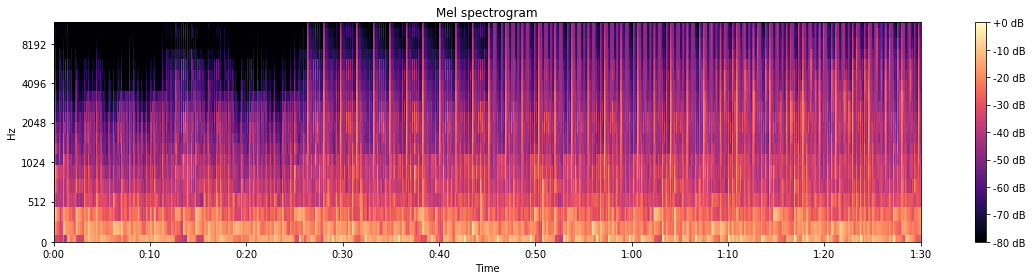

In [4]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

D = np.abs(librosa.stft(audio_subset))**2
#S = librosa.feature.melspectrogram(S=D)
S = librosa.feature.melspectrogram(y=audio_subset, sr=sr, n_mels=20, fmax=12000)

plt.figure(figsize=(16, 4))
spect = librosa.power_to_db(S, ref=np.max)
print (spect.shape)
librosa.display.specshow(spect,
                         sr=sr/2,
                         y_axis='mel', fmax=12000,
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [5]:
widths = [spect.shape[0] + 1 if kernel_size else spect.shape[0] + 2] + [8, 8, 8, 3]
ws1 = get_ws(widths, kernel_size=kernel_size)
ws2 = get_ws(widths, kernel_size=kernel_size)
num_weights = sum([w0 * w1 for i, (w0, w1) in enumerate(zip(widths[:-1], widths[1:]))])

In [6]:
time_of_each_frame = librosa.core.frames_to_time(np.arange(spect.shape[1]+1), sr=sr, hop_length=512)
spect_t = torch.FloatTensor((spect - spect.mean()) / spect.std()).cuda()
# spect_t[-5:] = spect_t[-5:] * 20

def get_im(xy, st, en, spect_t, ws, size_y, size_x, kernel_size, scale=1.0):
    spect_rep = spect_t[:, st:en].t().mean(0, keepdim=True)
    if kernel_size:
        xy = xy.view(1, 1, *xy.shape)
        spect_rep = spect_rep.view(*spect_rep.shape, 1, 1).repeat([1, 1, *xy.shape[-2:]])
        return forward(torch.cat([xy, spect_rep], 1) * scale, ws, size_y, size_x, kernel_size)
    spect_rep = spect_rep.repeat([xy.shape[0], 1])
    return forward(torch.cat([xy, spect_rep], 1) * scale, ws, size_y, size_x, kernel_size)

frame_rate = 25
weight_fade_seconds = 20
num_frames = frame_rate * seconds
step_size = spect_t.shape[1] / float(num_frames)
window_ratio = 3.
window_size = int(step_size * window_ratio)


ims = []
scale = 10
alpha = 0.0
for i_frame in tqdm(range(num_frames - 1)):
    st = np.abs(i_frame / float(frame_rate) - time_of_each_frame).argmin()
    en = st + window_size
    
    alpha += 1.0 / (weight_fade_seconds * frame_rate)
    if alpha >= 1.0:
        alpha = 0.0
        ws1 = [i * 1. for i in ws2]
        ws2 = get_ws(widths, kernel_size=kernel_size)
    ws = interp_ws(ws1, ws2, alpha)
    
    im = get_im(xy, st, en, spect_t, ws, size_y, size_x, kernel_size, scale=scale)
    ims.append(im)
    st = int(round(st + step_size))

100%|██████████| 1124/1124 [00:22<00:00, 50.15it/s]


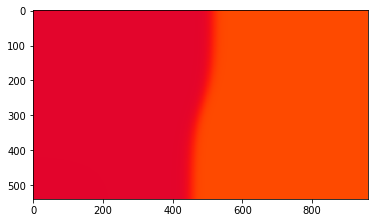

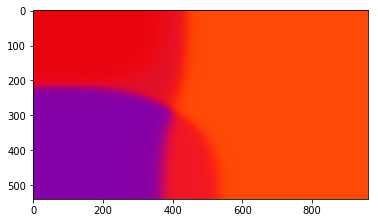

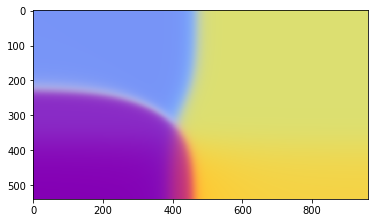

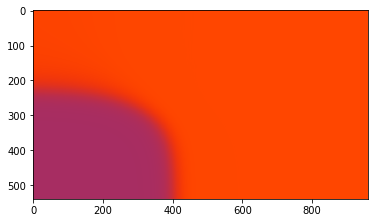

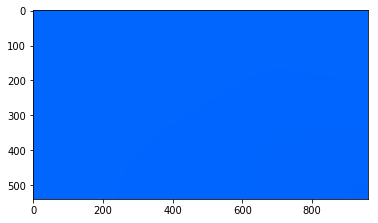

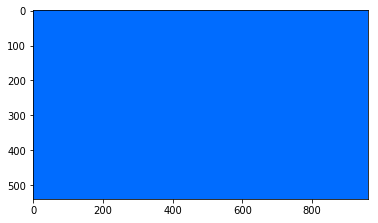

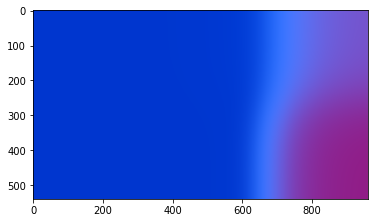

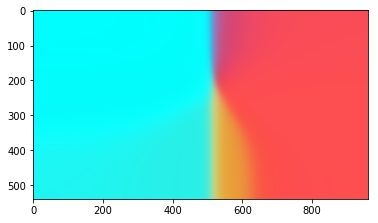

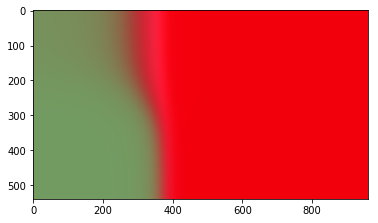

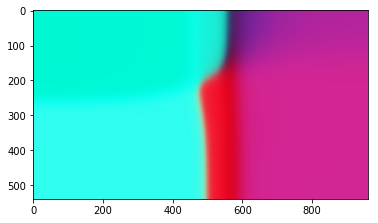

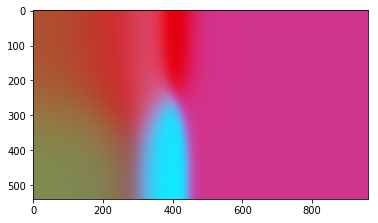

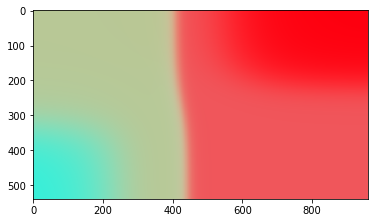

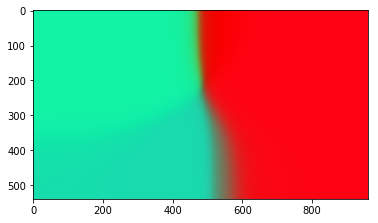

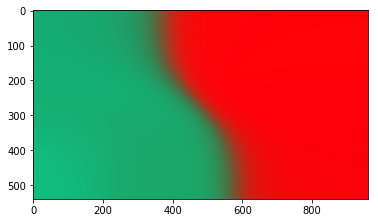

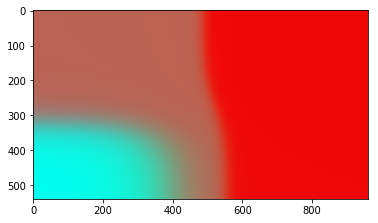

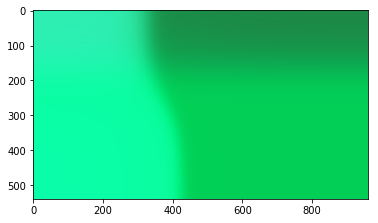

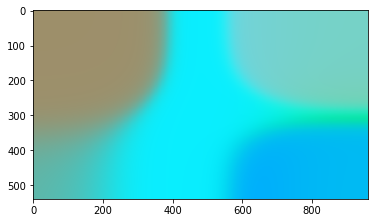

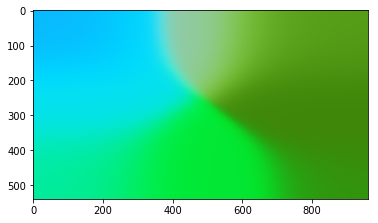

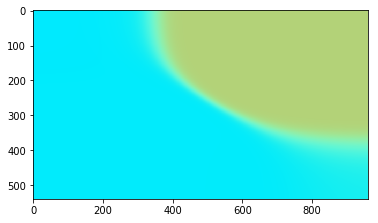

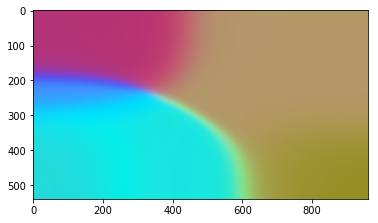

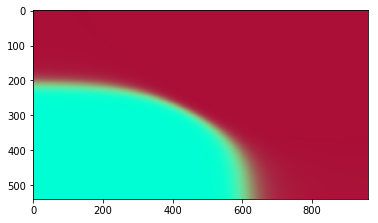

In [7]:
for im in ims[::len(ims)//20]:
    plt.imshow(im)
    plt.show()

In [8]:
from scipy.io.wavfile import write
write('tmp.wav', sr, np.clip((audio_subset * 32768.), -32768, 32768).astype(np.int16))

In [9]:
import os
import shutil
from skimage.color import hsv2rgb
hsv2rgb = lambda x: x
shutil.rmtree('cool2')
os.makedirs('cool2')
for i, im in tqdm(enumerate(ims)):
    plt.imsave('cool2/im%06d.png' % (i + 1), hsv2rgb(im))

1124it [01:47, 10.41it/s]


In [75]:
ws1 = get_ws(widths)
ws2 = get_ws(widths)

ims = []
num_frames = 200

now = time.time()
for alpha, o_x, o_y in zip(np.linspace(0, 1, num_frames),
                           np.linspace(-1, 1, num_frames),
                           np.linspace(-1, 1, num_frames)):
    ws_this = interp_ws(ws1, ws2, alpha)
    xy = meshgrid(size, o_x, o_y)
    out = forward(xy, ws_this)
    ims.append(out)
    
print (time.time() - now)

4.694384574890137
